# PyTorch Deep Learning Tutorial #
* Dhruv Srikanth
* 27 Feb 2025
* Neural Networks & Deep Learning

# Code

## Import Statements

In [12]:
# !pip install torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Load Dataset and Cast to Tensor

In [13]:
num_samples = 1000
input_size = 10

x_data_np = np.random.randn(num_samples, input_size).astype(np.float32)  # Features
y_data_np = np.random.randint(0, 2, num_samples).astype(np.int64)  # Binary labels (0 or 1)

# Convert to PyTorch tensors
x_data = torch.tensor(x_data_np, dtype=torch.float32)
y_data = torch.tensor(y_data_np, dtype=torch.long)



In [14]:
# Debugging: Data checks
print("=== Data Debugging ===")
print(f"x_data shape: {x_data.shape}, dtype: {x_data.dtype}")
print(f"y_data shape: {y_data.shape}, dtype: {y_data.dtype}")
print(f"x_data sample (first 2 rows): \n{x_data[:2]}")
print(f"y_data sample (first 5): {y_data[:5]}")
print(f"Label distribution: {np.bincount(y_data_np)}")
print(x_data_np.shape, x_data.shape)

=== Data Debugging ===
x_data shape: torch.Size([1000, 10]), dtype: torch.float32
y_data shape: torch.Size([1000]), dtype: torch.int64
x_data sample (first 2 rows): 
tensor([[-0.4959,  0.9934,  0.7557,  0.2844,  0.2007,  0.5996,  0.9399,  0.8731,
          0.4411, -1.2655],
        [ 0.1174, -1.3209,  0.9294, -0.9255, -2.4103, -0.0497, -0.1758,  0.3170,
          1.6929,  0.1250]])
y_data sample (first 5): tensor([0, 0, 0, 0, 1])
Label distribution: [511 489]
(1000, 10) torch.Size([1000, 10])


In [15]:
t = torch.zeros(1, 32, 1, 1, 64) #Gen new Tensor
print(t.shape) 
print(t.squeeze().shape) #Collapse unecessary dimensions of size `1, 

torch.Size([1, 32, 1, 1, 64])
torch.Size([32, 64])


In [16]:
t = torch.zeros(32, 64)
print(t.shape)
print(t.unsqueeze(0).shape) #Adds new dimension of size 1 in specified position

torch.Size([32, 64])
torch.Size([1, 32, 64])


## Define Custom Dataset

In [17]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = (x - x.mean(dim=0)) / x.std(dim=0)  # Transformation, feature-wise standardization
        self.y = y.float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] # Return features and label at index 'idx' as a tuple

In [18]:
dataset = CustomDataset(x_data, y_data)
train_size = int(0.7 * num_samples) #Calculate training set size, 70% of total
val_size = int(0.15 * num_samples)  #Calculate validation set size, 15% of total
test_size = num_samples - train_size - val_size #Calculate test set size, 15% of total

# Split dataset into train, val, test subsets randomly using random_split from torch.utils.data
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Shuffle to prevent arbitrary pattern memorization 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) #Do not shuffle to ensure reproducible results
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) #Do not shuffle to ensure reproducible results


A test set and a validation set serve different purposes in machine learning:
* Test set: Used only once at the end to evaluate the final model's performance on unseen data. It provides an unbiased estimate of how well your model will perform in production.
* Validation set: Used repeatedly during model development to tune hyperparameters, select features, or compare different models. It helps prevent overfitting to the training data without contaminating your final test results.


A DataLoader in PyTorch is a powerful utility that streamlines data handling by taking delivering a dataset in manageable batches, such as 32 samples at a time, as an iterable object, eliminating the need for manual indexing or batching; it offers features like shuffling to randomize sample order for better training, batching to group data for efficient processing, and optional parallelism to load data faster using multiple workers, making it ideal for feeding large datasets into a model during training or evaluation, as seen with your train_loader, val_loader, and test_loader, which you’d loop over in a training cycle.

We shuffle only the training data (train_loader) and not the validation (val_loader) or test (test_loader) data because shuffling helps the model learn better during training by preventing it from memorizing the order of samples, which could lead to overfitting or biased gradient updates, especially if the data has some unintended sequence (e.g., all positives first); for validation and testing, we keep the order fixed to ensure consistent, reproducible evaluation metrics—like accuracy or loss—since these phases are about assessing performance, not learning, and shuffling there could obscure how the model generalizes to a stable dataset.

In [19]:
for x, y in train_loader:
    print(f"Data batch shape: {x.shape}")   # (batch_size, channels, height, width)
    print(f"Label batch shape: {y.shape}")   # (batch_size,)
    break

Data batch shape: torch.Size([32, 10])
Label batch shape: torch.Size([32])


In [21]:
# Create synthetic data
X_trial = np.random.rand(1000, 10)  # 1000 samples, 10 features
y_trial = np.random.randint(0, 2, 1000)  # Binary labels

# Split into train and test sets (80% train, 20% test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_trial, y_trial, test_size=0.2, random_state=42)

X_train_tensor1 = torch.tensor(X_train1, dtype=torch.float32)
y_train_tensor1 = torch.tensor(y_train1, dtype=torch.long)

print(X_train_tensor1.shape, y_train_tensor1.shape)

torch.Size([800, 10]) torch.Size([800])


### TensorDataset

In [20]:
test_dataset = TensorDataset(x_data, y_data)
print(test_dataset)

### Existing Dataset

In [22]:
#Creates a pipeline of image transformations that converts images to PyTorch tensors
# Normalizes pixel values from [0,1] to [-1,1] by subtracting 0.5 and dividing by 0.5 for each RGB channel
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Loads the CIFAR-10 training dataset with parameters:
train_dataset_CIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True) 
test_dataset_CIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
reates a data loader for the training dataset that:

#Loads data in batches of 64 images, Shuffles the data for better training, Uses 2 worker processes for loading data in parallel
train_loader_CIFAR10 = DataLoader(train_dataset_CIFAR10, batch_size=64, shuffle=True, num_workers=2)
test_loader_CIFAR10 = DataLoader(test_dataset_CIFAR10, batch_size=64, shuffle=False, num_workers=2)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:04<00:00, 36230302.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define Your Model

In [24]:
class MLP(nn.Module): #Define Multi-Layer Perceptron inheriting from nn.Module
    def __init__(self, input_size, hidden_size, output_size, use_bias=True):
        super(MLP, self).__init__() #Initalize parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size, bias=use_bias) # First Fully Connected Layer 
        self.relu = nn.ReLU() #ReLU as activation
        self.dropout = nn.Dropout(p=0.5) #Dropout layer w p=1/2 to prevent overfitting
        self.fc2 = nn.Linear(hidden_size, output_size, bias=use_bias) # Second Fully Connected Layer
        self.sigmoid = nn.Sigmoid()  # Apply sigmoid for binary classification

    def forward(self, x): #Define the forward pass
        x = self.fc1(x) #Pass input through first layer
        x = self.relu(x) # Apply Activation 
        x = self.dropout(x) #Apply dropout
        x = self.fc2(x) #Pass through second layer
        x = self.sigmoid(x)  # Sigmoid for probability output
        return x

### LeakyReLU Implementation

In [25]:
class LeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(LeakyReLU, self).__init__() #Inherit 
        self.negative_slope = negative_slope

    def forward(self, x):
        return torch.where(x > 0, x, self.negative_slope * x) # torch.where is differentiable so no need for autograd Function
        # In cases where the forward function is differentiable, autograd will compute backward itself. 
        # But you can define gradient calculation in backward yourself!

x1 = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
activation = LeakyReLU()
activ2 = nn.LeakyReLU(0.01)
output = activation(x1)
print(output)
print(activ2(x1))

tensor([-0.0200, -0.0100,  0.0000,  1.0000,  2.0000])
tensor([-0.0200, -0.0100,  0.0000,  1.0000,  2.0000])


In [14]:
class CustomLeakyReLUManual:
    def __init__(self, negative_slope=0.01):
        self.negative_slope = negative_slope
        self.saved_input = None

    def forward(self, x):
        self.saved_input = x
        # Compute: f(x) = x if x > 0 else negative_slope * x
        mask = (x > 0).float()  # Create binary mask: 1 for positive values, 0 for non-positive
        output = mask * x + (1 - mask) * self.negative_slope * x  # Element-wise implementation of Leaky ReLU
        return output

    def __call__(self, x):
        return self.forward(x)

    def backward(self, grad_output):
        # The derivative is 1 for x > 0 and negative_slope for x <= 0.
        mask = (self.saved_input > 0).float()
        grad_input_factor = mask + (1 - mask) * self.negative_slope
        grad_input = grad_output * grad_input_factor
        return grad_input

activation = CustomLeakyReLUManual(negative_slope=0.1)
print(activation(x1))

tensor([-0.2000, -0.1000,  0.0000,  1.0000,  2.0000])


### Sequential Example

In [33]:
class MLP2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, use_bias=True, dropout_prob=0.5):
        super(MLP2, self).__init__()  # Initialize the parent class (nn.Module)
        self.fc1 = nn.Sequential(  # First layer group as a Sequential container
            nn.Linear(input_size, hidden_size, bias=use_bias),  # Linear transformation from input to hidden layer
            LeakyReLU(),  # LeakyReLU activation instead of ReLU for better gradient flow with negative values
            nn.Dropout(p=dropout_prob)  # Dropout with configurable probability to prevent overfitting
        )
        self.fc2 = nn.Sequential(  # Second layer group as a Sequential container
            nn.Linear(hidden_size, output_size, bias=use_bias),  # Linear transformation from hidden to output
            nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):  # Define the forward pass of the network
        x = self.fc1(x)  # Pass input through first Sequential block (Linear -> LeakyReLU -> Dropout)
        x = self.fc2(x)  # Pass through second Sequential block (Linear -> Sigmoid)
        return x  # Return the final output

This MLP2 class implements a streamlined two-layer neural network for binary classification. The architecture leverages PyTorch's nn.Sequential containers to group related operations (linear transformation, activation, and regularization) into logical blocks, improving code readability and maintainability. 

The first layer block uses LeakyReLU activation to prevent the "dying neuron" problem that can occur with standard ReLU, especially during early training. There's no activation function after the final layer's linear transformation except for the Sigmoid because the goal is to produce probability outputs between 0 and 1 for binary classification—adding ReLU here would disrupt this probability interpretation by zeroing out negative values. 

To extend this architecture for deeper networks, additional Sequential blocks could be inserted between fc1 and fc2, maintaining the same pattern of Linear → Activation → Dropout for each hidden layer, while keeping only the Sigmoid at the very end. For multi-class classification, the Sigmoid would be replaced with Softmax. The Sequential container simplifies the forward method by automatically applying each operation in order, eliminating the need to call each layer explicitly.

## Define your Hyperparameters, Model Instance, Loss Function, Optimizer

In [28]:
model = MLP(input_size, hidden_size=32, output_size=1, use_bias=True)  # Create MLP model with 32 hidden neurons and single output for binary classification
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for comparing predicted probabilities to binary target values
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with 0.01 learning rate to update model weights during training

In [27]:
num_epochs = 20  # Set training to run for 20 complete passes through the dataset
best_val_loss = float('inf')  # Initialize best validation loss to infinity to track improvement during training
best_model_path = "best_model.pth"  # File path where the best performing model weights will be saved

### Attributes

In [29]:
print(dict(model.named_modules()))
print(model)
summary(model, input_size=(input_size,))

{'': MLP(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
), 'fc1': Linear(in_features=10, out_features=32, bias=True), 'relu': ReLU(), 'dropout': Dropout(p=0.5, inplace=False), 'fc2': Linear(in_features=32, out_features=1, bias=True), 'sigmoid': Sigmoid()}
MLP(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             352
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                    [-1, 1]           

In [34]:
model2 = MLP2(input_size, hidden_size=32, output_size=1, use_bias=True)

In [35]:
print(model2)

MLP2(
  (fc1): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): LeakyReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [36]:
for name, param in model.named_parameters():
    print(f"{name} grad after backward: {param.grad}")

fc1.weight grad after backward: None
fc1.bias grad after backward: None
fc2.weight grad after backward: None
fc2.bias grad after backward: None


In [37]:
print(optimizer.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.01, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


In [38]:
for param_group in optimizer.param_groups:
    print(f"Learning rate: {param_group['lr']}")
    print(f"Momentum: {param_group.get('momentum', 0)}")  # May not exist if momentum=0

Learning rate: 0.01
Momentum: 0


### Other

In [39]:
optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [40]:
for param_group in optimizer2.param_groups:
    print(f"Learning rate: {param_group['lr']}")
    print(f"Momentum: {param_group.get('momentum', 0)}")  # May not exist if momentum=0

Learning rate: 0.01
Momentum: 0.9


In [41]:
optimizer3 = optim.SGD([
    {'params': model.fc1.parameters(), 'lr': 0.01},  # First layer
    {'params': model.fc2.parameters(), 'lr': 0.001}  # Second layer
], momentum=0.9)

In [42]:
criterion2 = nn.CrossEntropyLoss()

## Training Loop (with Validation)

In [43]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    if epoch == 0:
      print(model.fc1.weight.grad)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets.float())
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Save model if it has the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{num_epochs}], New Best Val Loss: {val_loss:.4f} (Model Saved)")

    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

tensor([[-6.0552e-03, -2.5819e-03, -1.0290e-03,  3.5275e-03,  2.8513e-05,
          2.2542e-03, -1.1770e-04, -3.7763e-03, -6.9934e-03,  3.1529e-03],
        [ 5.6408e-03, -9.4813e-03,  5.7554e-03, -4.6646e-03,  5.3211e-03,
          2.9401e-03,  6.0625e-04,  6.3660e-03,  1.7393e-02, -1.3188e-02],
        [-2.0303e-03, -8.2473e-03,  4.7185e-03,  6.5037e-03, -1.2722e-02,
         -4.9726e-03, -5.7361e-03, -1.3714e-02, -2.1118e-02, -3.4878e-03],
        [-5.5206e-03, -4.3736e-03, -4.8126e-03,  1.4298e-02,  8.6906e-03,
         -6.4575e-03, -4.1295e-03, -6.2262e-03,  4.7301e-03, -4.4787e-03],
        [ 1.2059e-03, -1.6554e-03,  2.8338e-02,  2.0252e-02,  5.6300e-03,
          6.6502e-03,  4.7723e-03,  1.8284e-02,  1.8467e-03,  7.6139e-03],
        [ 3.9048e-03,  1.5291e-03,  1.5002e-03,  5.7621e-03,  3.9061e-03,
         -2.2411e-03, -3.4703e-03,  3.6924e-03,  1.4712e-03,  3.3170e-04],
        [-1.6072e-03, -1.7148e-03,  4.1069e-03, -5.0296e-03,  4.1537e-03,
          2.6551e-03, -2.9185e-0

### On GPU

In [44]:
model2 = MLP2(input_size, hidden_size=32, output_size=1, use_bias=True)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model2.parameters(), lr=0.01)

num_epochs = 20
best_val_loss2 = float('inf')
best_model_path2 = "best_model2.pth"

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
model2.to(device)
ops = np.array([])
train_losses = []

for epoch in range(num_epochs):
    model2.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model2(inputs).squeeze()
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model2(inputs).squeeze()
            loss = criterion(outputs, targets.float())
            val_loss += loss.item()
            ops = np.concatenate((ops, outputs.detach().cpu().numpy()), axis=None)

    val_loss /= len(val_loader)

    # Save model if it has the best validation loss
    if val_loss < best_val_loss2:
        best_val_loss2 = val_loss
        torch.save(model2.state_dict(), best_model_path2)
        print(f"Epoch [{epoch+1}/{num_epochs}], New Best Val Loss: {val_loss:.4f} (Model Saved)")

    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/20], New Best Val Loss: 0.6844 (Model Saved)
Epoch [2/20], New Best Val Loss: 0.6831 (Model Saved)
Epoch [3/20], Train Loss: 0.6802, Val Loss: 0.6918
Epoch [4/20], Train Loss: 0.6867, Val Loss: 0.6946
Epoch [5/20], Train Loss: 0.6805, Val Loss: 0.6950
Epoch [6/20], Train Loss: 0.6842, Val Loss: 0.6947
Epoch [7/20], Train Loss: 0.6820, Val Loss: 0.6970
Epoch [8/20], Train Loss: 0.6714, Val Loss: 0.7006
Epoch [9/20], Train Loss: 0.6759, Val Loss: 0.7088
Epoch [10/20], Train Loss: 0.6700, Val Loss: 0.7027
Epoch [11/20], Train Loss: 0.6729, Val Loss: 0.7043
Epoch [12/20], Train Loss: 0.6706, Val Loss: 0.7045
Epoch [13/20], Train Loss: 0.6744, Val Loss: 0.7097
Epoch [14/20], Train Loss: 0.6672, Val Loss: 0.7075
Epoch [15/20], Train Loss: 0.6710, Val Loss: 0.7013
Epoch [16/20], Train Loss: 0.6620, Val Loss: 0.7130
Epoch [17/20], Train Loss: 0.6646, Val Loss: 0.7144
Epoch [18/20], Train Loss: 0.6721, Val Loss: 0.7110
Epoch [19/20], Train Loss: 0.6646, Val Loss: 0.7048
Epoch [20/20], 

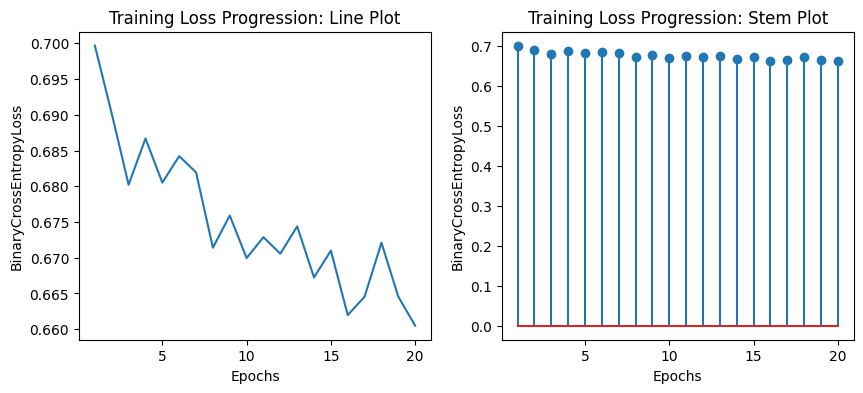

Shape of outputs concatenated: (3000,)


In [32]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot([i+1 for i in range(len(train_losses))], train_losses)
plt.xlabel('Epochs')
plt.ylabel('BinaryCrossEntropyLoss')
plt.title('Training Loss Progression: Line Plot')

plt.subplot(1, 2, 2)
plt.stem([i+1 for i in range(len(train_losses))], train_losses)
plt.xlabel('Epochs')
plt.ylabel('BinaryCrossEntropyLoss')
plt.title('Training Loss Progression: Stem Plot')

plt.show()

print('Shape of outputs concatenated:', ops.shape)

In [33]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler.step() in loop

## Test Model

### Load Best Model from Saved Path

In [34]:
best_model = MLP(input_size, hidden_size=32, output_size=1, use_bias=True)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

<ipython-input-34-4ae2ef599980>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


MLP(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Testing Loop

In [35]:
correct = 0
total = 0
test_loss = 0.0

preds, labs = np.array([]), np.array([])

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = best_model(inputs).squeeze()
        predicted = (outputs >= 0.5).long()  # Convert probabilities to 0 or 1
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        preds = np.concatenate((preds, predicted.detach().numpy()), axis=None)
        labs = np.concatenate((labs, targets.detach().numpy()), axis=None)

        loss = criterion(outputs, targets.float())
        test_loss += loss.item()

test_loss /= len(test_loader)
accuracy = correct / total

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Loss: 0.7032
Test Accuracy: 54.67%


F1 Score: 0.5526315789473685
Confusion Matrix:
 [[40 33]
 [35 42]]


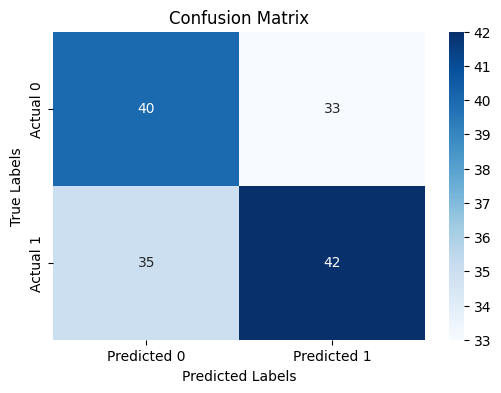

In [36]:
import seaborn as sns

f1 = f1_score(labs, preds, average='binary')
print("F1 Score:", f1)

# Compute the confusion matrix.
cm = confusion_matrix(labs, preds)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix using seaborn's heatmap.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()